In [11]:
from ultralytics import YOLO
import requests
from SPARQLWrapper import SPARQLWrapper, POST, TURTLE, JSON
import networkx as nx
import matplotlib.pyplot as plt
import rdflib
from datetime import datetime

In [12]:
import logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s', 
    handlers=[
        logging.FileHandler('logs/'+datetime.now().strftime("log_%Y-%m-%d_%H-%M-%S.log"), encoding='utf-8')
    ]
)

In [13]:
YOLO_MODEL = 'yolo11x.pt'
IMAGE_PARH = 'images/image.jpg'
RDF_BASE_ENDPOINT = "http://localhost:7200"
REPOSITORY_NAME = "yolo"

In [14]:
def detect_objects(image_path):
    """
    Detects objects in an image using a YOLO object detection model.

    Args:
        image_path (str): The path to the image file where objects will be detected.

    Returns:
        list: A list of detected object class names. If no objects are detected or an error occurs, an empty list is returned.
    """

    logging.info(f"Starting object detection for image: {image_path}")
    
    try:
        # Load the YOLO model from the specified path
        model = YOLO('models/'+YOLO_MODEL)
        logging.info("YOLO model loaded successfully.")

        # Run object detection on the input image
        results = model(image_path, verbose=False)

        # Check if any objects were detected
        if not results or not results[0].boxes:
            logging.warning(f"No objects detected in image: {image_path}")
            return []
        
        # Extract the class names for each detected object
        classes = [model.names[int(box.cls)] for box in results[0].boxes]
        logging.info(f"Detected classes: {classes}")
        
        return classes
        
    except Exception as e:
        logging.error(f"Error during object detection: {e}")
        return []


In [15]:
def get_conceptnet_relations(concepts):
    """
    Fetches relations from ConceptNet for a list of given concepts and constructs an RDF graph.

    Args:
        concepts (list): A list of concepts (strings) for which ConceptNet relations will be fetched.

    Returns:
        rdflib.Graph: An RDF graph representing the relations between the concepts in ConceptNet.
    """
    
    base_url = "https://api.conceptnet.io/c/en/"
    graph = rdflib.Graph()

    logging.info("Starting to fetch ConceptNet relations for concepts.")
    CN = rdflib.Namespace("http://conceptnet.io")

    for concept in concepts:
        offset = 0
        limit = 2000
        logging.info(f"Fetching relations for concept: {concept}")

        while True:
            # Construct the URL to fetch relations for the current concept
            url = f"{base_url}{concept}?limit={limit}&offset={offset}"
            try:
                logging.debug(f"Requesting data from: {url}")
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
            except requests.exceptions.RequestException as e:
                logging.error(f"Request failed for concept {concept} with error: {e}")
                break
            
            # Iterate over the edges (relations) in the fetched data
            for edge in data.get("edges", []):
                rel = edge.get("rel", {}).get("@id", "")
                start = edge.get("start", {}).get("@id", "")
                end = edge.get("end", {}).get("@id", "")

                # Skip if any required fields are missing
                if not rel or not start or not end:
                    continue
                
                # Create RDF URIs for the start concept, relation, and end concept
                start_uri = CN[start]
                end_uri = CN[end]
                rel_uri = CN[rel]

                # Add the relation to the RDF graph
                graph.add((start_uri, rel_uri, end_uri))
                logging.debug(f"Added relation: {start_uri} -> {rel_uri} -> {end_uri}")

            # Check if we have fetched all relations for the current concept
            if len(data.get("edges", [])) < limit:
                logging.info(f"Fetched all relations for concept: {concept}")
                break

            # Increment the offset to fetch the next set of relations
            offset += limit

    logging.info("Finished fetching ConceptNet relations.")
    return graph

In [16]:
def insert_rdf_to_graphdb(rdf_graph):
    """
    Inserts RDF data into a GraphDB repository.

    Args:
        rdf_graph (rdflib.Graph): The RDF graph to be inserted into GraphDB.
    
    Logs:
        - The progress of the insertion process.
        - Errors if any occur during the process.
    """
    logging.info("Starting RDF insertion to GraphDB.")

    try:
        # Initialize the SPARQLWrapper with the GraphDB repository endpoint
        sparql = SPARQLWrapper(RDF_BASE_ENDPOINT + "/repositories/" + REPOSITORY_NAME + "/statements")

        # Serialize the RDF graph to Turtle format for insertion
        rdf_data = rdf_graph.serialize(format='turtle')
        logging.debug(f"Serialized RDF data: {rdf_data[:200]}...")

        # Set up the SPARQL query to insert the RDF data into the GraphDB repository
        sparql.setQuery("""
            INSERT DATA { 
                %s
            }
        """ % rdf_data)

        # Set the request method and return format
        sparql.setMethod(POST)
        sparql.setReturnFormat(TURTLE)

        logging.info("Sending RDF data to GraphDB.")
        
        # Execute the query to insert the data
        sparql.query()
        logging.info("RDF data successfully inserted into GraphDB.")
    
    except Exception as e:
        logging.error(f"Error inserting RDF data into GraphDB: {e}")

In [17]:
def extract_KG(concepts):
    """
    Extracts a Knowledge Graph (KG) based on the given concepts by querying a ConceptNet SPARQL endpoint.

    Args:
        concepts (list): A list of concepts (strings) to query the Knowledge Graph for.

    Returns:
        networkx.Graph: A graph representing the relationships between the concepts and their related entities.
    
    Logs:
        - Information about the execution process (query execution, graph construction, etc.).
        - Errors if any occur during the process.
    """

    # Build a SPARQL query that searches for relationships involving the provided concepts
    query = """
    PREFIX cn: <http://conceptnet.io/c/en/>
    SELECT ?subject ?predicate ?object
    WHERE {
        {
            ?subject ?predicate ?object .
            FILTER (?subject IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """) ||
            ?object IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """))
        }
        UNION
        {
            ?subject ?predicate ?object .
            ?object ?predicate2 ?subject2 .
            FILTER (?subject IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """) ||
            ?object IN (""" + ",".join([f"cn:{concept}" for concept in concepts]) + """))
        }
    }
    LIMIT 1000
    """

    # Initialize the SPARQL wrapper and set the endpoint
    sparql = SPARQLWrapper(RDF_BASE_ENDPOINT+"/repositories/"+REPOSITORY_NAME)    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    try:
        # Execute the SPARQL query to retrieve data
        logging.debug("Sending SPARQL query to retrieve data.")
        results = sparql.query().convert()
        logging.info("SPARQL query executed successfully.")
    except Exception as e:
        # Log any errors during the query execution
        logging.error(f"Error executing SPARQL query: {e}")
        return
    
    # Initialize a new graph for the Knowledge Graph
    G = nx.Graph()
    logging.info("Building the graph from the query results.")

    # Iterate through the results and add edges to the graph
    for result in results["results"]["bindings"]:
        subject = result["subject"]["value"].split('/')[-1]
        predicate = result["predicate"]["value"].split('/')[-1]
        obj = result["object"]["value"].split('/')[-1]

        # Add an edge between the subject and object with the predicate as the label
        G.add_edge(subject, obj, label=predicate)

    logging.info("Graph construction complete. Now removing irrelevant nodes.")


    # Remove nodes that are not relevant to the given concepts
    nodes_to_remove = []

    for node in G.nodes():
        related_concepts = [n for n in G[node] if any(concept == n for concept in concepts)]
        if len(related_concepts) == 1 and not any(concept == node for concept in concepts):
            nodes_to_remove.append(node)

    G.remove_nodes_from(nodes_to_remove)
    
    # Return the constructed graph
    return G

In [18]:
def plot_KG(concepts):
    """
    Fetches data from a SPARQL endpoint, constructs a Knowledge Graph (KG) from the query results, and visualizes the graph.

    Args:
        concepts (list): A list of concepts (strings) to highlight in the Knowledge Graph.

    Logs:
        - Information about the execution process (fetching data, building the graph, etc.).
        - Errors if any occur during the process.
    """

    logging.info("Starting to plot the Knowledge Graph.")

    G = extract_KG(concepts)

    # Assign colors to the nodes: highlight the concepts in light green
    color_map = []
    for node in G.nodes():
        if any(concept == node for concept in concepts):
            color_map.append('lightgreen')
        else:
            color_map.append('yellow')

    logging.info("Starting the visualization of the graph.")

    # Plot the graph using a spring layout
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.4)
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=1000)
    nx.draw_networkx_edges(G, pos, alpha=0.7)

    # Draw edge labels (relations between nodes)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Customize edge styles based on the relation type
    for u, v, data in G.edges(data=True):
        if data['label'] == 'IsA':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='black', style='dotted')
        elif data['label'] == 'relatedTo':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='black', style='dashed')
        else:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, edge_color='black', style='solid')

    # Draw node labels and customize the font properties
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

    # Title and axis adjustments
    plt.title("Graph with Concepts Highlighted")
    plt.axis("off")
    plt.show()
    
    logging.info("Graph visualization complete.")

In [19]:
def generate_rdf_description(concepts):
    """
    Generates an RDF description based on the Knowledge Graph (KG) of the provided concepts.

    This function calls the `extract_KG` function to build a Knowledge Graph from the given concepts.
    It then serializes the graph into the Turtle RDF format and returns the serialized data.

    Args:
        concepts (list): A list of concepts (strings) for which the RDF description will be generated.

    Returns:
        str: The RDF description serialized in the Turtle format.

    Logs:
        - Information about the execution process (graph construction, RDF serialization).
    """

    # Extract the Knowledge Graph (KG) based on the given concepts
    graph = extract_KG(concepts)

    # Convert networkx graph to rdflib Graph
    rdf_graph = rdflib.Graph()

    # Iterate through the networkx graph and add triples to the rdflib graph
    for u, v, data in graph.edges(data=True):
        # Create URIRef for the nodes and the edge
        subject = rdflib.URIRef(f"http://example.org/{u}")
        obj = rdflib.URIRef(f"http://example.org/{v}")
        predicate = rdflib.URIRef(f"http://example.org/{data['label']}")

        # Add the triple to the rdflib graph
        rdf_graph.add((subject, predicate, obj))
    
    logging.info("RDF graph construction complete. Serializing the graph.")

    # Serialize the graph into Turtle format
    rdf_data = rdf_graph.serialize(format="turtle")
    logging.info("RDF description generation complete.")
    
    # Return the serialized RDF data
    return rdf_data

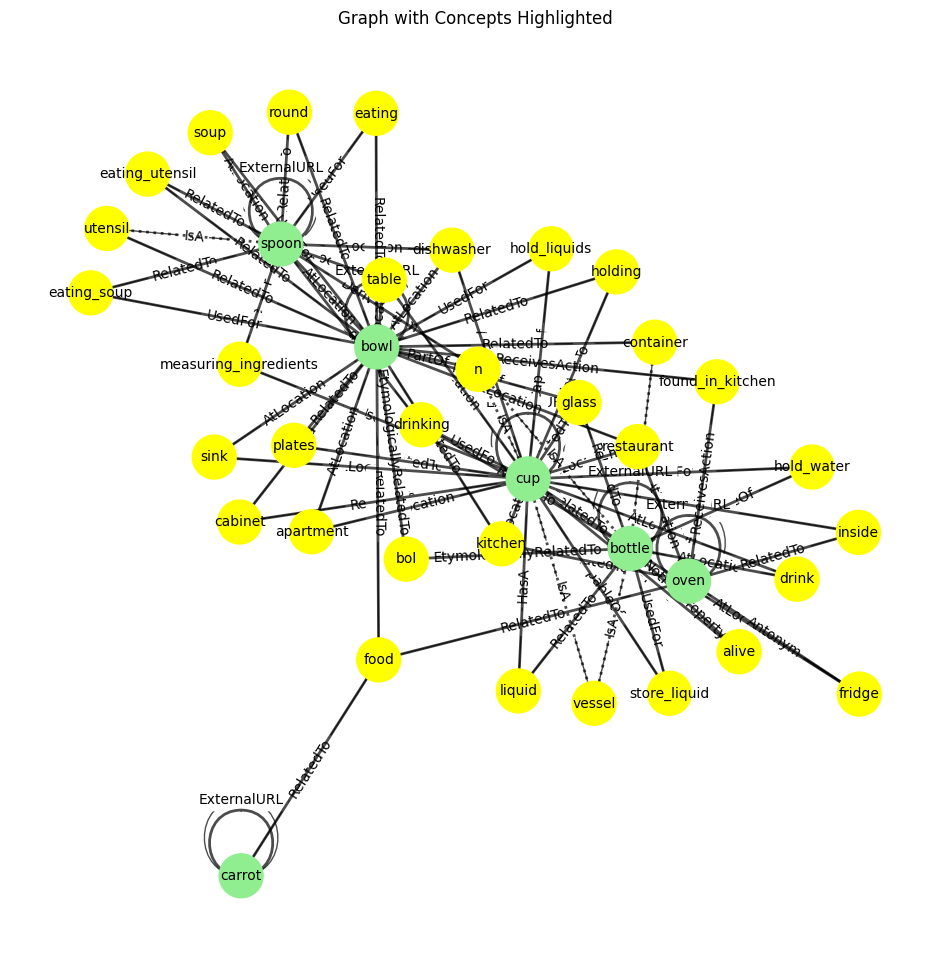

@prefix ns1: <http://example.org/> .

ns1:alive ns1:NotHasProperty ns1:bottle .

ns1:apartment ns1:AtLocation ns1:bowl .

ns1:cabinet ns1:AtLocation ns1:bowl .

ns1:cup ns1:AtLocation ns1:apartment,
        ns1:dishwasher,
        ns1:drink,
        ns1:kitchen,
        ns1:restaurant,
        ns1:sink,
        ns1:table ;
    ns1:CapableOf ns1:hold_liquids,
        ns1:store_liquid ;
    ns1:ExternalURL ns1:cup ;
    ns1:HasA ns1:liquid ;
    ns1:IsA ns1:n,
        ns1:vessel ;
    ns1:NotHasProperty ns1:alive ;
    ns1:RelatedTo ns1:bottle,
        ns1:cabinet,
        ns1:glass,
        ns1:holding,
        ns1:inside,
        ns1:plates ;
    ns1:UsedFor ns1:drinking,
        ns1:hold_water,
        ns1:measuring_ingredients .

ns1:dishwasher ns1:AtLocation ns1:bowl,
        ns1:spoon .

ns1:drink ns1:AtLocation ns1:bottle .

ns1:drinking ns1:RelatedTo ns1:bottle ;
    ns1:UsedFor ns1:spoon .

ns1:eating ns1:RelatedTo ns1:bowl .

ns1:eating_soup ns1:UsedFor ns1:bowl .

ns1:eating_u

In [20]:
concepts = detect_objects(IMAGE_PARH)
rdf_graph = get_conceptnet_relations(concepts)
insert_rdf_to_graphdb(rdf_graph)
plot_KG(concepts)
description = generate_rdf_description(concepts)
print(description)